# Notebook for the Appendix run: what if we only include countries with lots of wearing change?

Operationalised as > 15% difference in min wearing and max wearing

In [3]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import (
    RandomWalkMobilityModel,
    MandateMobilityModel
)
import epimodel.viz.mandate_wearing as mw

from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.prior_posterior as pp

import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
import json

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set_style("white")


import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw

Set Theano Environmental Variables for Parallelisation


In [70]:
# argparser = argparse.ArgumentParser()
# argparser.add_argument('--model', dest='model', type=str, help='Model type')
# argparser.add_argument('--filter', dest='filtered', type=str, help='How to remove regions')
# argparser.add_argument('--masks', dest='masks', type=str, help='Which mask feature')
# argparser.add_argument('--w_par', dest='w_par', type=str, help='Which wearing parameterisation')
# argparser.add_argument('--mob', dest='mob', type=str, help='Which wearing parameterisation')
# args, _ = argparser.parse_known_args()

MODEL = "cases" #args.model
FILTERED = "nofilter" #args.filtered
MASKS = "wearing" #args.masks
W_PAR = "exp" # None

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

TUNING = 1000
DRAWS = 500
CHAINS = 4

if MASKS == "mandate":
    n_mandates = 2
    


In [59]:
path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

../data/modelling_set/master_data_mob_include_us_True_m_w.csv


# Which countries have low range in wearing?

In [60]:
df = masks_object.df.reset_index()

def get_countries_with_low_wearing_range(df):
    regions_in_model_set = masks_object.df.reset_index().country.unique()
    maxs = df.groupby("country").max("percent_mc")["percent_mc"]
    mins = df.groupby("country").min("percent_mc")["percent_mc"]

    diffs = (maxs - mins).sort_values()
    return diffs[diffs < 0.15].index

def get_region_indices(leaveouts):
    country_leavout_inds = []
    
    for r in leaveouts:
        if r in masks_object.Rs:
            i = masks_object.Rs.index(r)
            country_leavout_inds += [i]
            
    return country_leavout_inds

            
countries_with_low_wearing_range = get_countries_with_low_wearing_range(df)
inds = get_region_indices(countries_with_low_wearing_range)

In [67]:
# prep data object

path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

if MASKS == "mandate":
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True, n_mandates=n_mandates)
if MASKS == "wearing":
    print(MASKS)
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True)#, country_leavout_inds=inds)

masks_object.make_preprocessed_object()
data = masks_object.data

../data/modelling_set/master_data_mob_include_us_True_m_w.csv
wearing
['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [68]:
print("How many regions?:", len(data.Rs))
print("How many NPIs?:", len(data.CMs))
print("How many days?:", len(data.Ds))

#len(data.Rs)* (len(data.Ds) - 30)
data.CMs

How many regions?: 66
How many NPIs?: 11
How many days?: 144


['C1_School closing',
 'C1_School closing_full',
 'C2_Workplace closing',
 'C2_Workplace closing_full',
 'C4_Restrictions on gatherings_3plus',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C4_Restrictions on gatherings_2plus',
 'C4_Restrictions on gatherings_full',
 'avg_mobility_no_parks_no_residential',
 'percent_mc']

In [69]:
# model specification
ep = EpidemiologicalParameters()
bd = ep.get_model_build_dict()


def set_init_infections(data, d):
    n_masked_days = 10
    first_day_new = data.NewCases[:, n_masked_days]
    first_day_new = first_day_new[first_day_new.mask == False]
    median_init_size = np.median(first_day_new)

    if median_init_size == 0:
        median_init_size = 50

    d["log_init_mean"] = np.log(median_init_size)
    d["log_init_sd"] = np.log(median_init_size)  # TODO: wide


set_init_infections(data, bd)

bd['wearing_parameterisation'] = W_PAR


if MODEL == "cases":
    del bd["deaths_delay_mean_mean"]
    del bd["deaths_delay_mean_sd"]
    del bd["deaths_delay_disp_mean"]
    del bd["deaths_delay_disp_sd"]

    
if MASKS == "mandate":
    bd['n_mandates'] = 1
    #bd['mask_mean'] = 0.2 / bd['n_mandates']
    bd['mask_sigma'] = 0.2
    
print(bd)
print(W_PAR)

{'gi_mean_mean': 5.06, 'gi_mean_sd': 0.3265, 'gi_sd_mean': 2.11, 'gi_sd_sd': 0.5, 'cases_delay_mean_mean': 10.92830227448381, 'cases_delay_mean_sd': 0.9387435298564465, 'cases_delay_disp_mean': 5.406593726647138, 'cases_delay_disp_sd': 0.2689502951493133, 'log_init_mean': 5.033700567027251, 'log_init_sd': 5.033700567027251, 'wearing_parameterisation': 'exp'}
exp


/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [71]:
if MASKS == "wearing":
    with RandomWalkMobilityModel(data) as model:
        model.build_model(**bd)
        
elif MASKS == "mandate":
    with MandateMobilityModel(data) as model:
        model.build_model(**bd)
    

MASS = 'adapt_diag' 

with model:
    model.trace = pm.sample(
        DRAWS,
        tune=TUNING,
        cores=CHAINS,
        chains=CHAINS,
        max_treedepth=12,
        target_accept=0.9,
        init=MASS,
    )

7477
Argument: cases_delay_mean_sd not being used
Argument: cases_delay_disp_sd not being used
exp


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Psi, InitialSize_log, GI_sd, GI_mean, r_walk_noise, r_walk_noise_scale, RegionR_noise, HyperRVar, HyperRMean, Mobility_Alpha, Wearing_Alpha, CM_Alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 8217 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [75]:
hdr_trace = model.trace

In [94]:
dt = datetime.datetime.now().strftime("%m-%d-%H:%M")
Rs = data.Rs

if MASKS == 'wearing':
    idstr = f"pickles/only_15plus_wearing_range_{MASKS}_{W_PAR}_{MODEL}_countries_{len(Rs)}_{dt}"
else:
    idstr = f"pickles/{MASKS}_2and3_{MODEL}_countries_{len(Rs)}_{dt}"

pickle.dump(model.trace, open(idstr + ".pkl", 'wb'))

with open(idstr + "_cols", "w") as f:
    f.write( ", ".join(data.CMs) )

In [72]:
var = ["CMReduction"]
if MASKS == "wearing" :
    var += ["WearingReduction"]
else :
    var += ["MandateReduction"]
var += ["MobilityReduction"]

#var += ["HyperRVar", "HyperRMean"]

s = pm.summary(model.trace, var_names=var, hdi_prob=0.95)
#npi_cols = data.CMs[:-2] + [data.CMs[-1]] + [data.CMs[-2]]
#s.index = npi_cols
s

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
CMReduction[0],1.072,0.076,0.948,1.232,0.002,0.002,996.0,974.0,1134.0,872.0,1.0
CMReduction[1],0.932,0.060,0.807,1.038,0.002,0.001,1121.0,1121.0,1186.0,1168.0,1.0
CMReduction[2],0.980,0.035,0.906,1.047,0.001,0.001,1495.0,1495.0,1538.0,1184.0,1.0
CMReduction[3],0.931,0.058,0.809,1.029,0.002,0.002,738.0,738.0,748.0,837.0,1.0
CMReduction[4],0.993,0.051,0.882,1.089,0.001,0.001,1302.0,1302.0,1386.0,1033.0,1.0
CMReduction[5],0.976,0.044,0.886,1.059,0.001,0.001,882.0,882.0,904.0,937.0,1.0
CMReduction[6],1.011,0.052,0.917,1.123,0.002,0.001,1062.0,1055.0,1103.0,1134.0,1.0
CMReduction[7],1.047,0.062,0.937,1.179,0.002,0.001,1163.0,1122.0,1322.0,884.0,1.0
CMReduction[8],0.988,0.044,0.900,1.076,0.001,0.001,1197.0,1197.0,1235.0,1232.0,1.0
WearingReduction[0],0.687,0.093,0.496,0.856,0.005,0.004,383.0,352.0,422.0,517.0,1.0


In [74]:
1 - np.median(model.trace.WearingReduction)

0.31664583634927945

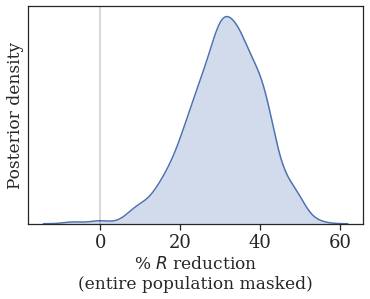

In [98]:
def main_result_posteriors(wred, ax):
    sns.kdeplot(wred, shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction\n(entire population masked)", fontsize=17)
    #ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    ax.set_ylabel("Posterior density", fontsize=17)
    ax.tick_params(axis='both', which='both', labelsize=18)
    
ax = plt.gca()
main_result_posteriors((1 - hdr_trace.WearingReduction.reshape(2000,)) * 100, ax)

In [ ]:
from pathlib import Path

exp_pkl = "wearing_exp_cases_countries_92_05-31-02:56.pkl" # 1000 + 700 

def load_pickle(p) :
    path = 'pickles/' + p
    with open(path, 'rb') as buff:
        trace = pickle.load(buff)

    colfile = path[:-4] + "_cols"
    
    cf = Path(colfile)
    if cf.is_file():
        with open(colfile, "r") as f:
            npi_cols = f.read().split(", ")
    else :
        print("cols missing")
        npi_cols = []
    
    return trace, npi_cols


exp_trace, npi_cols = load_pickle(exp_pkl)


In [ ]:
from epimodel.plotting.intervention_plots import combine_npi_samples
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

def setup_plot(y_ticks = True, xlabel=True, x_lims=(-25, 100)):
    plt.figure(figsize=(4.5, 3), dpi=400)

    ax = plt.gca()
    x_min, x_max = x_lims
    xrange = np.array([x_min, x_max])
    plt.fill_between(xrange, 0.13, 0.87, color="silver", alpha=0.25, linewidth=0)

    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
#     plt.ylabel("Mask-wearing", rotation=0, fontsize=6)

    plt.axvline(0, linestyle="--", color="black", linewidth=0.5)
    plt.yticks([])#plt.yticks([0.5, "Mask-wearing"])

    plt.xticks(xtick_vals, xtick_str, fontsize=9)
    plt.xlim([x_min, x_max])
    plt.ylim([0, 1])

    plt.xlabel("Reduction in R", fontsize=9)
        

def add_trace_to_plot(samples, y_off, col, label, alpha, width, npi_comb_dict, cm_names, size=9):
    #comb_effects, new_names = combine_npi_samples(npi_comb_dict, samples, cm_names)
    comb_effects = samples
    comb_effects = 100*(1-comb_effects)
    npi_order = list(npi_comb_dict.keys())
    nF = len(npi_order)

    y_vals = -np.array([npi_order.index(name) for name in new_names])
    plt.plot([1], [1], color=col, linewidth=1, alpha=alpha, label=label)

    li, lq, m, uq, ui = np.percentile(comb_effects, [2.5, 25, 50, 75, 97.5], axis=0)
    plt.scatter(m, y_vals+y_off, marker="o", color=col, s=size, alpha=alpha, facecolor='white', zorder=3, linewidth=width/2)

    plt.plot([li[0], ui[0]], [y_vals[0]+y_off, y_vals[0]+y_off], color=col, alpha=alpha*0.25, linewidth=width, zorder=2)
    plt.plot([lq[0], uq[0]], [y_vals[0]+y_off, y_vals[0]+y_off], color=col, alpha=alpha*0.75, linewidth=width, zorder=2)


cols = sns.color_palette('colorblind')
default_label = "All regions"

title = "Wearing posterior in regions with high range in wearing"
grouped_dict = {
     'Mask-wearing' : {
        'npis': ['percent_mc'],
        'type': 'include',
        'color': cols[0],
        'main': True,
     }
}


setup_plot()
y_off = -np.linspace(-0.3, 0.6, 1)


highRangeSamples = np.array(trace.WearingReduction)
add_trace_to_plot(np.array(highRangeSamples), 
                  0.65, 
                  cols[0], 
                  "Regions w/ 15%+ range", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

samples = np.array(exp_trace.WearingReduction)
add_trace_to_plot(np.array(samples), 
                  0.35, 
                  (0,0,0), 
                  "All regions", 
                  alpha=1,
                  width=2, 
                  npi_comb_dict=grouped_dict, 
                  cm_names=["wearing"] )

plt.legend(shadow=True, fancybox=True, bbox_to_anchor=(0.99, 0.02), fontsize=7, loc="lower right") 
plt.title(title, fontsize=10)



#plt.show()

#plt.xticks()
plt.savefig(f"../outputs/high_dynamic_range_posterior.pdf", bbox_inches="tight")